#**👋👶🏻 Fingly : 손유희 기반 유아 홈스쿨링 서비스 🏠**
- **Main goal** : 신체운동기능과 인지능력이 급속으로 발달하는 시기인 영유아기(만 0-5세)의 유아가 동요에 맞춰 손동작을 따라하는 율동 학습을 통해 동작, 언어, 운율 기반의 다양한 상호작용을 경험하도록 돕는 것
- **Keyword** : Pose Estimation, Mediapipe, Classification, Real-time
- **Related Concepts**
  - **Human Pose Estimation**
    - Semantic key points를 검출하고 points간의 관련성을 예측하여 사람의 자세를 추정하는 Computer vision task
    - key points 인식 대상은 알고리즘 활용 목적에 따라 인체, 손, 발 등 다양하게 설정 가능
  - **Media-Pipe**
    - Google에서 제작한 실시간 스트리밍 media 인식/분석을 위한 ML 솔루션을 제공하는 플랫폼
    - Face detection/mesh, Selfie segmentation 등 인체를 대상으로 하는 다양한 인식 모델 제공
    - 본 서비스에서는 총 21개의 points로 구성된 **Hand Landmark model** 활용

- **Project Summary** : https://www.notion.so/Fingly-bc0389cdebea4c0a9a16da4899019987

## 1. Dataset 수집 및 가공

① Mediapipe Hand Model과 OpenCV로 각 손유희 동작마다 Landmark 녹화

② 3D Point 위치를 기반으로 손가락 각도 계산 (여러 방향에서의 연속적인 데이터 수집)

→ **Raw data** : 3D Point 위치(x,y,z) 21*3개 + visibility 21개 + 손가락 각도 15개 + 정답 라벨 1개

③ Sequence length 30개씩 쪼개서 LSTM(Window size = 30) 모델 학습을 위한 **Seq data** 생성

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import time
import os

In [ ]:
old_actions = ['rabbit', 'mountain', 'go', 'santa', 'snow', 'nose', 'butterfly', 'flower', 'bird']
new_actions = ['fat', 'thin']
actions = old_actions + new_actions
new_idx = len(old_actions)

seq_length = 30
secs_for_action = 30

## MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)

created_time = int(time.time())
os.makedirs('dataset', exist_ok=True)

while cap.isOpened():
    for idx, action in enumerate(actions[new_idx:]):
    # for idx, action in enumerate(actions):
        data = []

        ret, img = cap.read()

        img = cv2.flip(img, 1)

        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()

        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21, 4))
                    for j, lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                    # Compute angles between joints
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # [20, 3]

                    # Normalize v
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # Get angle using arcos of dot product
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # Convert radian to degree

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx+new_idx)

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        # np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

        # Create sequence data
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_0'), full_seq_data)
    break

## 2. 분류 모델 정의 및 학습

- 율동이 포함된 실시간 영상을 Inference 하고자 순서가 있는 영상 데이터에서 그 다음을 예측할 수 있는 **LSTM** 모델 사용
- Classification 위한 **Dense layer** 연결 (last node 수 = action 개수)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Github/Ybigta/2022-2_conference_Fingly

/content/drive/MyDrive/Colab Notebooks/Github/Ybigta/2022-2_conference_Fingly


In [3]:
!pip install tensorflow

In [4]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
actions = ['rabbit', 'mountain', 'go', 'santa', 'snow', 'nose', 'butterfly', 'flower', 'bird']

data = np.concatenate([
    np.load('dataset/seq_rabbit_0.npy'),
    np.load('dataset/seq_mountain_0.npy'),
    np.load('dataset/seq_go_0.npy'),
    np.load('dataset/seq_santa_0.npy'),
    np.load('dataset/seq_snow_0.npy'),
    np.load('dataset/seq_nose_0.npy'),
    np.load('dataset/seq_butterfly_0.npy'),
    np.load('dataset/seq_flower_0.npy'),
    np.load('dataset/seq_bird_0.npy')
], axis=0)

data.shape

(6968, 30, 100)

In [6]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6968, 30, 99)
(6968,)


In [7]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(6968, 9)

In [8]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6271, 30, 99) (6271, 9)
(697, 30, 99) (697, 9)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 9)                 297       
                                                                 
Total params: 44,361
Trainable params: 44,361
Non-trainable params: 0
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
194/196 [============================>.] - ETA: 0s - loss: 5.3406 - acc: 0.5503
Epoch 1: val_acc improved from -inf to 0.75323, saving model to models/model.h5
196/196 [==============================] - 5s 18ms/step - loss: 5.3014 - acc: 0.5516 - val_loss: 0.9802 - val_acc: 0.7532 - lr: 0.0010
Epoch 2/200
193/196 [============================>.] - ETA: 0s - loss: 0.7018 - acc: 0.8151
Epoch 2: val_acc improved from 0.75323 to 0.85222, saving model to models/model.h5
196/196 [==============================] - 4s 19ms/step - loss: 0.6970 - acc: 0.8161 - val_loss: 0.5004 - val_acc: 0.8522 - lr: 0.0010
Epoch 3/200
196/196 [==============================] - ETA: 0s - loss: 0.4460 - acc: 0.8895
Epoch 3: val_acc improved from 0.85222 to 0.93113, saving model to models/model.h5
196/196 [==============================] - 3s 14ms/step - loss: 0.4460 - acc: 0.8895 - val_loss: 0.2505 - val_acc: 0.9311 - lr: 0.0010
Epoch 4/200
194/196 [============================>.] - ETA: 0s - loss: 0.

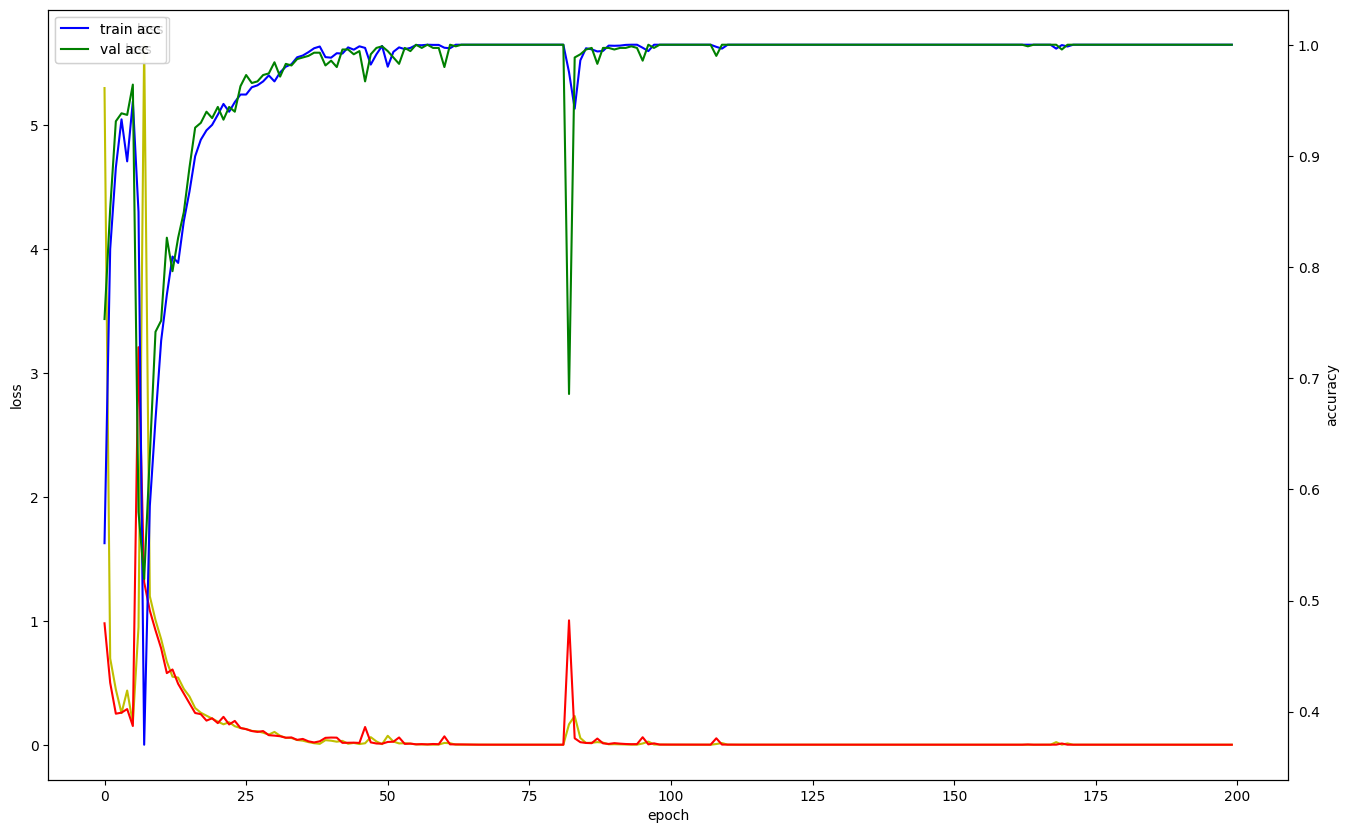

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [12]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

22/22 [==============================] - 0s 7ms/step


array([[[580,   0],
        [  0, 117]],

       [[586,   0],
        [  0, 111]],

       [[608,   0],
        [  0,  89]],

       [[644,   0],
        [  0,  53]],

       [[593,   0],
        [  0, 104]],

       [[649,   0],
        [  0,  48]],

       [[636,   0],
        [  0,  61]],

       [[634,   0],
        [  0,  63]],

       [[646,   0],
        [  0,  51]]])

## 3. 인식 및 판단 로직 (모델 오류 개선)

- Confidence score 90% 이상일 때만 동작으로 인식하고, 연속적으로 들어오는 frame 대해 3번 연속 같은 동작일 때만 유효한 동작으로 판단

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from PIL import ImageFont, ImageDraw, Image

In [ ]:
font_kor = ImageFont.truetype("fonts/gulim.ttc", 20)

actions = ['rabbit', 'mountain', 'go', 'santa', 'snow', 'nose', 'butterfly', 'flower', 'bird', 'fat', 'thin', 'cute']
seq_length = 30

model = load_model('models/model.h5')

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)

seq = []
action_seq = []

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21, 4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # [20, 3]

            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue

            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

            y_pred = model.predict(input_data).squeeze()

            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]

            # (1) Confidence score 90% 이상일 때만 동작으로 인식
            if conf < 0.9:
                continue

            action = actions[i_pred]
            action_seq.append(action)

            if len(action_seq) < 3:
                continue
            this_action = '?'

            # (2) 연속적으로 들어오는 frame 대해 3번 연속 같은 동작일 때만 유효한 동작으로 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action

            cv2.putText(img, f'토끼',
                        org=(int(res.landmark[0].x * img.shape[1]), int(res.landmark[0].y * img.shape[0] + 20)),
                        fontFace=font_kor, fontScale=1, color=(255, 255, 255), thickness=2)

    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        break

## 4. 정답 판정 알고리즘

- 가사에 알맞은 동작을 실행했을 경우 맞다고 판정 
- → 각 동요별로 사용자 동작 결과에 대한 전체 스코어 산출 & 틀린 동작은 wrong action list에 추가

- +) 난이도 모드(easy/hard) 선택 기능 : 동작을 인식하는 정답 구간의 길이가 길면 ‘easy’ 모드, 짧으면 ‘hard’ 모드

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
import time
from PIL import ImageFont, ImageDraw, Image

In [ ]:
# 인식 및 판단 로직을 추가한 class 정의
class action_answer() :
    def __init__(self,model,actions,seq_length,correct_actions,correct_act_ko,cut_time_original,stroke_fill):
        self.model = model  # model
        self.actions = actions # 총 action
        self.seq_length = seq_length # 인식되는 sequence 길이
        self.correct_actions = correct_actions # 정답 action
        self.correct_act_ko = correct_act_ko # 정답 action 한국어 버전

        plus_list = [6] * len(cut_time_original) # 카메라 delay 시간
        self.cut_time = [a+b for a,b in zip(cut_time_original,plus_list)] # action 실행 구간
        self.test_time = self.cut_time[-1] # 총 영상 길이
        self.stroke_fill = stroke_fill

    # 유저의 동작을 list 형태로 보냄
    def answer(self) :
        # 손 모양 캐치
        mp_hands = mp.solutions.hands
        mp_drawing = mp.solutions.drawing_utils
        hands = mp_hands.Hands(
            max_num_hands=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5)
        seq = []
        action_seq = []
        labels = []
        
        max_time = time.time() + self.test_time  # 종료 시간 설정
        cut_time = self.cut_time
        cut_time_list = [] 
        c_time = time.time() # 시작 시간

        # 동작 구분 시간
        for i in range(len(cut_time)) :
            t = c_time + cut_time[i]
            cut_time_list.append(t)

        # 카메라 켜기
        cap = cv2.VideoCapture(0)
        while True:
            ret, img = cap.read()
            img0 = img.copy()
            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            fontpath = "BMJUA_ttf.ttf"
            font = ImageFont.truetype(fontpath, 50)
            img_pil = Image.fromarray(img)
            draw = ImageDraw.Draw(img_pil)

            # 특정 시간에 행동 명령어 출력
            for i in range(len(self.correct_actions)):
                if (time.time() < min(cut_time_list[i+1],cut_time_list[i]+5)) & (time.time() >= cut_time_list[i])  :
                    # do_action = 'Now ' + self.correct_actions[i] + ' motion!' # 영어 버전
                    do_action = '이제, ' + self.correct_act_ko[i] + ' 동작 해봐요!' # 한국어 버전
                    draw.text((60, 30), f'{do_action.upper()}', font=font, fill=(255,255,255),stroke_width=3,stroke_fill=self.stroke_fill)
                    img = np.array(img_pil)
  
            # 손의 landmark 정보를 통해 사용자의 행동 정보 list 추출
            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21, 4))
                    for j, lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                    # Compute angles between joints
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # [20, 3]

                    # Normalize v
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # Get angle using arcos of dot product
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # Convert radian to degree
                    d = np.concatenate([joint.flatten(), angle])
                    seq.append(d)
                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

                    if len(seq) < self.seq_length: # 설정한 시퀀스 킬이보다 클 경우만 이후 명령어 실행
                        continue

                    input_data = np.expand_dims(np.array(seq[-self.seq_length:], dtype=np.float32), axis=0)

                    y_pred = self.model.predict(input_data).squeeze()

                    i_pred = int(np.argmax(y_pred))
                    conf = y_pred[i_pred]

                    # (1) Confidence score (라벨에 대한 최대 예측 점수) 90% 이상일 때만 동작으로 인식
                    if conf < 0.9:
                        continue

                    action = self.actions[i_pred]
                    action_seq.append(action)

                    if len(action_seq) < 3:
                        continue
                    this_action = '?'

                    # (2) 연속적으로 들어오는 frame 대해 3번 연속 같은 동작일 때만 유효한 동작으로 판단
                    if action_seq[-1] == action_seq[-2] == action_seq[-3]: # 연속된 3개의 action_seq
                        this_action = action

                    if this_action in self.correct_actions: # 출력된 action이 동요에 알맞는 action 인지 확인
                        c_time = time.time() 
                        # 동작 구분 시간을 구함으로써 중복 제거 방지
                        cut_off = [i for i in range(len(cut_time_list)-1) if (c_time>=cut_time_list[i])&(c_time<cut_time_list[i+1])]
                        if len(labels) == 0 :
                            labels.append([this_action,time.time(),cut_off])
                        else : 
                            if this_action != labels[-1][0]: # 전 동작과 같은 동작을 반복해서 인식하는 경우 하나의 동작 실행으로 받아들임
                                labels.append([this_action,time.time(),cut_off]) 
                            else :
                                if cut_off != labels[-1][-1]: # 반복하지만 동작 구분 시간이 다른 경우 다른 동작의 실행으로 받아들임
                                    labels.append([this_action,time.time(),cut_off]) 
            cv2.imshow('img', img)

            # 설정한 종료 시간이 되면 while 문 탈출
            if time.time() > max_time :
                        break
            if cv2.waitKey(1) == ord('q'):
                break
        
        return  labels, cut_time_list

In [ ]:
# 사용자 동작 결과에 대한 score 산출
class Score_test():
    def __init__(self, actions, correct_actions, labels, cut_time_list) :
        self.correct_actions = correct_actions # 정답 action
        self.labels = labels[:-1] # 사용자 동작 결과
        self.cut_time_list = cut_time_list # 동작 구분 시간
    
    def score(self,level = 'easy') : # 레벨에 따른 다른 score 산출 방식
        if len(self.labels) == 0 :
            score =  0
            wrong_action = self.correct_actions
            return score, wrong_action
        wrong_action = []
        score = 0
        num_correct = len(self.correct_actions)

        # 사용자의 동작 결과가 정답보다 적을 경우 남은 갯수만큼 빈 list로 채우기(out of index를 방지하기 위함)
        if len(self.labels) < num_correct :
            for n in range(num_correct-len(self.labels)) :
                self.labels.append([0,0])
        labels = np.array(self.labels,dtype=object)
        print(labels)
        labels = labels[:,:-1] # 동작 구분 시간 결과값 떼어내기

        if level == 'easy' :
            # 정답을 기준으로 사용자 행동 결과를 하나씩 비교
            for i in range(num_correct) :
                # 정답과 같은 위치에 사용자 동작 결과가 들어왔는지 확인
                if self.correct_actions[i] == labels[i,0] : 
                    # 해당 동작이 정확한 동작 구분 시간에 실행했으면 맞다고 처리
                    if (float(labels[i][1])>=self.cut_time_list[i]) & (float(labels[i][1])<=self.cut_time_list[i+1]) :
                        score += 1
                    else : 
                        # 제일 마지막 동작이 동작 구분시간 안에 없으면 틀림(out of index 방지)
                        if i == len(labels) :
                            wrong_action.append(self.correct_actions[i]) 
                        else :
                            # 중간에 오답이 있어 올바른 행동의 결과가 정답과 다른 위치에서 있는 것을 확인하고 맞다고 처리
                            if self.correct_actions[i] in labels[i+1:,0] :
                                idx = np.where(labels == self.correct_actions[i])
                                k = 0
                                for j in idx[0]:
                                    if (float(labels[j][1])>=self.cut_time_list[i]) & (float(labels[j][1])<=self.cut_time_list[i+1]) :
                                        score += 1
                                        k += 1
                                # 사용자 동작 결과에서 올바른 동작의 동작 구분시간의 범위에 없는 경우
                                if k == 0 :
                                    wrong_action.append(self.correct_actions[i])
                            # 오답인 행동과 같은 행동이 뒷 index에 없는 경우
                            else :
                                wrong_action.append(self.correct_actions[i])  
                else : 
                    # 정답과 다른 위치에 사용자 동작 결과가 있는지 확인
                    if self.correct_actions[i] in labels[:,0] :
                        idx = np.where(labels == self.correct_actions[i])
                        k = 0
                        for j in idx[0]:
                            if (float(labels[j][1])>=self.cut_time_list[i]) & (float(labels[j][1])<=self.cut_time_list[i+1]) :
                                score += 1
                                k += 1
                        if k == 0 :
                            wrong_action.append(self.correct_actions[i])
                    else :
                        wrong_action.append(self.correct_actions[i])

        elif level == 'hard' :
            # 'easy' mode와 실행 원리는 같음 (동작 구분 시작의 구간이 더욱 짧아진 것만 다름)
            for i in range(num_correct) :
                if self.correct_actions[i] == labels[i,0] :
                    if (float(labels[i][1])>=self.cut_time_list[i]) & (float(labels[i][1])<=self.cut_time_list[i+1]) :
                        score += 1
                    else : 
                        if i == len(labels) :
                            wrong_action.append(self.correct_actions[i]) 
                        else :
                            if self.correct_actions[i] in labels[i+1:,0] :
                                idx = np.where(labels == self.correct_actions[i])
                                k = 0
                                for j in idx[0]:
                                    if (float(labels[j][1])>=self.cut_time_list[i]) & (float(labels[j][1])<=self.cut_time_list[i]+3) :
                                        score += 1
                                        k += 1
                                if k == 0 :
                                    wrong_action.append(self.correct_actions[i])
                            else :
                                wrong_action.append(self.correct_actions[i])  
                else : 
                    if self.correct_actions[i] in labels[:,0] :
                        idx = np.where(labels == self.correct_actions[i])
                        k = 0
                        for j in idx[0]:
                            if (float(labels[j][1])>=self.cut_time_list[i]) & (float(labels[j][1])<=self.cut_time_list[i]+3) :
                                score += 1
                                k += 1
                        if k == 0 :
                            wrong_action.append(self.correct_actions[i])
                    else :
                        wrong_action.append(self.correct_actions[i])
            else : 
                print('Input correct level')
        score /= num_correct
        return score, wrong_action

## 5. Test

In [ ]:
# 설정한 action
actions = ['rabbit', 'mountain', 'go','santa','snow', 'nose','butterfly','flower', 'bird','bear','fat', 'thin','cute']

# 1 : 루돌프 , 2 : 곰 세마리, 3 : 산토끼, 4 : 나비야
# 동요의 action
correct_actions_3= ['rabbit','go', 'mountain']
correct_actions_1 = ['twinkle', 'nose','santa']
correct_actions_4 = ['butterfly','flower', 'bird']
correct_actions_2 = ['bear','fat', 'thin','cute']

# action 한국어 버전
correct_act_ko_3 = ['토끼','간다','산']
correct_act_ko_1 = ['반짝','코','산타']
correct_act_ko_4 = ['나비','꽃','참새']
correct_act_ko_2 = ['곰','뚱뚱해','날씬해','귀여워']

# 시퀀스 길이
seq_length = 30

# 동요별 cut_time
cut_time_3 = [3,14,18,35]
cut_time_1 = [0,4,10,20]
cut_time_4 = [4,23,31,38]
cut_time_2 = [0,6,13,20,29] 

# 동요별 글자 색깔
stroke_fill_3 = (81,164,75)
stroke_fill_1 = (85,82,246)
stroke_fill_4 = (241,175,76)
stroke_fill_2 = (69,91,125)

# 모델
model = load_model('models/model.h5')

# score test 실행
song_num = str(input('Input your song number : ')) # 노래 선택
level = str(input('Input your level : ')) # 난이도 선택

In [ ]:
# 노래별로 test
def test_by_song(song_num,level='easy'):
    # 노래에 따른 변수 생성
    correct_actions = globals()['correct_actions_' + song_num]
    correct_act_ko = globals()['correct_act_ko_' + song_num]
    cut_time = globals()['cut_time_' + song_num]
    stroke_fill = globals()['stroke_fill_' + song_num]
    
    # 노래에 따른 test 실행 
    answer = action_answer(model,actions,seq_length,correct_actions,correct_act_ko,cut_time,stroke_fill)
    labels, cut_time_list = answer.answer()
    test = Score_test(actions, correct_actions, labels, cut_time_list)
    score, wrong_action = test.score(level=level)

    print(score)
    print(wrong_action)

test_by_song(song_num,level)

## Demo 영상

https://www.youtube.com/watch?v=V4WWk4vjBEw&list=PLIZ3mKAU9ragn1woIEWls9zaV1p69rq1D&index=8